# Task
Load the Parquet Files

## Load the specified parquet file

### Subtask:
Convert from bytes to pixel brightness



**Reasoning**:
Update the file path in the existing code cell to load the specified parquet file and execute the cell.



## Inspect the dataframe

### Subtask:
Save to pandas df



**Reasoning**:
Display the column names, data types, and first few rows of the DataFrame to understand its structure and the nature of the image data.



## Extract and display images

### Subtask:
Based on the DataFrame structure, write code to extract the image data (e.g., if it's in a specific column) and display the images. This might require using libraries like Pillow or OpenCV.


**Reasoning**:
Import PIL and iterate through the first few rows of the dataframe to extract and display the images.



In [4]:
# Ensure pyarrow is installed in this kernel
!pip install --quiet pyarrow
!pip install pandas Pillow kagglehub ipywidgets numpy matplotlib pyarrow


In [5]:

import pandas as pd
from PIL import Image
import io
import numpy as np
import os
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import matplotlib.pyplot as plt


In [6]:
import pandas as pd
from PIL import Image
import io
import numpy as np
import os
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import matplotlib.pyplot as plt

# Ensure a 'data' directory exists for the parquet files
if not os.path.exists('data'):
    os.makedirs('data')

# Load parquet files
# Make sure to reference download instructions. You have to download the kaggle dataset and upload it, rename it to a data directory. Video guide coming soon
#from: https://drive.google.com/drive/folders/12-1XR8df-rYkwJuMqMgXYQ9dm6EoDx0f?usp=drive_link
#quickstart guide: https://www.youtube.com/watch?v=WPRarAeelAM
#Original source + description: https://advp.niagads.org/downloads
train_df = pd.read_parquet("data/train.parquet")
test_df  = pd.read_parquet("data/test.parquet")

def bytes_to_pixels(b: bytes) -> np.ndarray:
    """
    Convert raw image bytes (e.g. JPEG/PNG) into a 2D numpy array of pixel values (grayscale).
    """
    img = Image.open(io.BytesIO(b))  # convert to grayscale
    return np.array(img)
def extract_bytes(blob):
    """
    Unwrap a dict‐wrapped binary payload if needed,
    otherwise return blob directly.
    """
    if isinstance(blob, dict):
        # try common keys
        for key in ("bytes", "data", "image"):
            if key in blob and isinstance(blob[key], (bytes, bytearray)):
                return blob[key]
        # fallback: first bytes‐like value
        for v in blob.values():
            if isinstance(v, (bytes, bytearray)):
                return v
        raise TypeError(f"No bytes found in dict payload: {list(blob.keys())}")
    return blob

train_df["image"] = train_df["image"].apply(lambda blob: bytes_to_pixels(extract_bytes(blob)))
test_df["image"]  = test_df["image"].apply(lambda blob: bytes_to_pixels(extract_bytes(blob)))

1. label = 2


C:\Users\sanir\AppData\Local\Temp\ipykernel_8204\4051836937.py:10: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(pixels.astype("uint8"), mode="L")


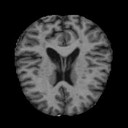

2. label = 0


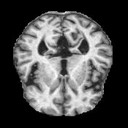

3. label = 3


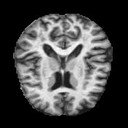

4. label = 3


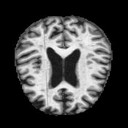

5. label = 2


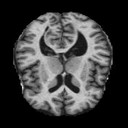

6. label = 2


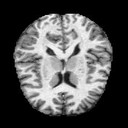

7. label = 2


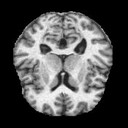

8. label = 2


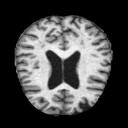

9. label = 3


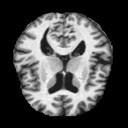

10. label = 2


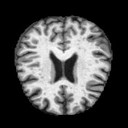

In [7]:
def display_images(df, n=10):
    """
    Display the first n grayscale images (numpy arrays) from df
    along with their labels. Assumes df has columns 'image' and 'label'.
    """
    for i, (_, row) in enumerate(df.head(n).iterrows(), start=1):
        pixels = row["image"]
        label = row.get("label", "")
        # Create a PIL image in 'L' mode (8-bit pixels, black and white)
        img = Image.fromarray(pixels.astype("uint8"), mode="L")
        print(f"{i}. label = {label}")
        display(img)
display_images(train_df)

#### Checking DATA frame Size

In [8]:
train_df.shape, test_df.shape


((5120, 2), (1280, 2))

### Check Level Distribution

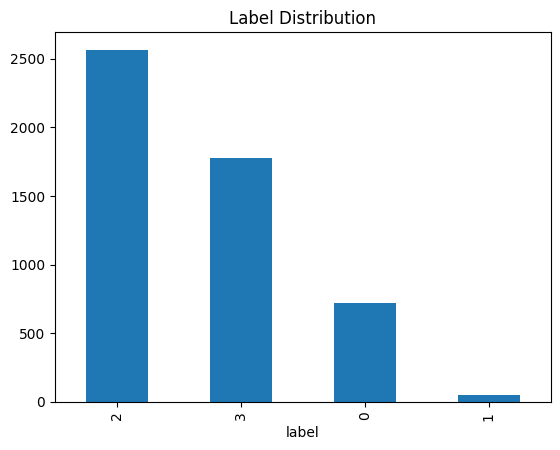

In [9]:
train_df['label'].value_counts().plot(kind='bar')
plt.title("Label Distribution")
plt.show()


 ### Show sample images per class


Class: 2


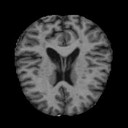

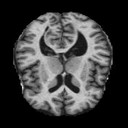

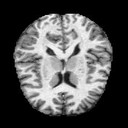


Class: 0


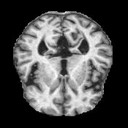

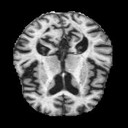

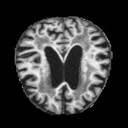


Class: 3


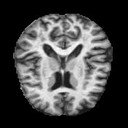

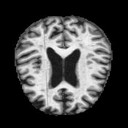

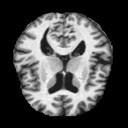


Class: 1


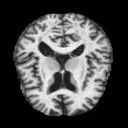

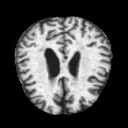

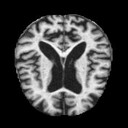

In [10]:
def show_samples_per_class(df, n=3):
    classes = df['label'].unique()
    for cls in classes:
        subset = df[df['label'] == cls].head(n)
        print(f"\nClass: {cls}")
        for i, row in subset.iterrows():
            display(Image.fromarray(row['image'].astype("uint8")))
            
show_samples_per_class(train_df)


## Image Preprocessing

In [11]:
import tensorflow as tf

IMG_SIZE = 128

def preprocess(img):
    img = Image.fromarray(img.astype("uint8")).resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=-1)  # grayscale channel
    return img

train_df["processed"] = train_df["image"].apply(preprocess)
test_df["processed"]  = test_df["image"].apply(preprocess)


### Train/Validation Split

In [12]:
from sklearn.model_selection import train_test_split

X = np.stack(train_df["processed"].values)
y = train_df["label"].values

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_val.shape


((4096, 128, 128, 1), (1024, 128, 128, 1))

### Building Baseline CNN

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(16, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    layers.MaxPooling2D(),
    
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


c:\Users\sanir\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 826,436 (3.15 MB)

 Trainable params: 826,436 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

### Train Baseline Model

In [14]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)




Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.5127 - loss: 1.0216 - val_accuracy: 0.5654 - val_loss: 0.9254
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.6003 - loss: 0.8747 - val_accuracy: 0.6055 - val_loss: 0.8467
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.6719 - loss: 0.7540 - val_accuracy: 0.7090 - val_loss: 0.6817
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7749 - loss: 0.5353 - val_accuracy: 0.7881 - val_loss: 0.5268
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8577 - loss: 0.3505 - val_accuracy: 0.8857 - val_loss: 0.3192
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.9263 - loss: 0.2033 - val_accuracy: 0.9102 - val_loss: 0.2590
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.9646 - loss: 0.1056 - val_accuracy: 0.9414 - val_loss: 0.1628
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.9880 - loss: 0.0469 - val_accu

### Evaluate Your Model

#### Accuracy

In [15]:
val_loss, val_acc = model.evaluate(X_val, y_val)
val_acc


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9473 - loss: 0.1508


0.947265625

#### Confusion Matrix

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


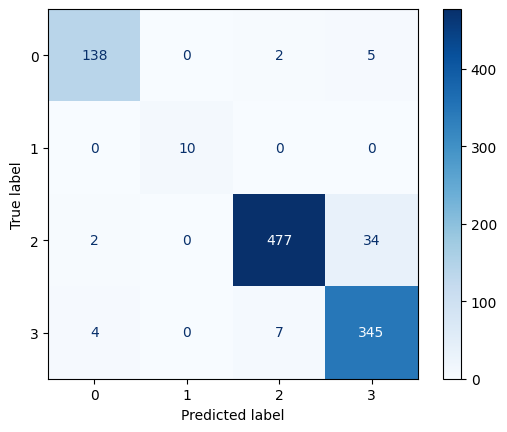

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds = np.argmax(model.predict(X_val), axis=1)
cm = confusion_matrix(y_val, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.show()


#### Classification Report

In [23]:
# Sometimes the issue is with le.classes_
print(f"le.classes_ type: {type(le.classes_)}")
print(f"le.classes_: {le.classes_}")

# Ensure classes are strings
target_names = [str(cls) for cls in le.classes_]

# Clean the y_val and preds
y_val_clean = np.array(y_val).ravel().astype(int)
preds_clean = np.array(preds).ravel().astype(int)

print(classification_report(y_val_clean, preds_clean, target_names=target_names))

le.classes_ type: <class 'numpy.ndarray'>
le.classes_: [0 1 2 3]
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       145
           1       1.00      1.00      1.00        10
           2       0.98      0.93      0.95       513
           3       0.90      0.97      0.93       356

    accuracy                           0.95      1024
   macro avg       0.96      0.96      0.96      1024
weighted avg       0.95      0.95      0.95      1024



## Transfer Learning + Augmentation

### Data Augmentation

In [24]:
import tensorflow as tf
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(factor=0.2),
], name="data_aug")


In [25]:
IMG_SIZE = 224

def preprocess_for_tl(img):
    # Ensure image has the right dimensions
    if len(img.shape) == 2:  # Grayscale (H, W)
        img = np.repeat(img[..., np.newaxis], 3, axis=-1)  # Convert to (H, W, 3)
    elif len(img.shape) == 3 and img.shape[-1] == 1:  # Grayscale with channel dim
        img = np.repeat(img, 3, axis=-1)
    # If already RGB (H, W, 3), leave as is
    
    # Resize
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img

train_df["tl_img"] = train_df["image"].apply(lambda x: preprocess_for_tl(x))
test_df["tl_img"] = test_df["image"].apply(lambda x: preprocess_for_tl(x))

### Build Transfer Learning Model

### Recommended Model: EfficientNetB3


### EfficientNetB3 Transfer Learning Block

In [33]:
from tensorflow.keras.applications import MobileNetV2, ResNet50

# MobileNetV2 might be more flexible with input shapes
base = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(le.classes_), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### Train Phase 1 (Frozen)


In [36]:
# First, let's see what we're working with
print("Debugging current data:")
print(f"X_train type: {type(X_train)}")
print(f"X_train shape: {X_train.shape}")
print(f"X_train dtype: {X_train.dtype}")

# If X_train has wrong shape, fix it immediately
if len(X_train.shape) == 3:  # (batch, H, W) instead of (batch, H, W, C)
    print("Converting grayscale to RGB...")
    X_train = np.stack([X_train] * 3, axis=-1)
    X_val = np.stack([X_val] * 3, axis=-1)
    
print(f"Fixed X_train shape: {X_train.shape}")
print(f"Fixed X_val shape: {X_val.shape}")

# Also ensure the values are in proper range
if X_train.max() > 1.0:
    X_train = X_train.astype(np.float32) / 255.0
    X_val = X_val.astype(np.float32) / 255.0

Debugging current data:
X_train type: <class 'numpy.ndarray'>
X_train shape: (4096, 128, 128, 1)
X_train dtype: float64
Fixed X_train shape: (4096, 128, 128, 1)
Fixed X_val shape: (1024, 128, 128, 1)


In [37]:
history_1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)


Epoch 1/10


ValueError: Input 0 of layer "functional_2" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(32, 128, 128)